In [3]:
import json

In [6]:

from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt 
import glob

In [ ]:

suffix='31_cap_suppressions'

glob.glob(f'/nfs/scratch_2/bjoern/atman_other_model/others/BLIP/test_folder/*_explanation_{suffix}*')

['/nfs/scratch_2/bjoern/atman_other_model/others/BLIP/test_folder/cute-kitten-and-puppy-outdoors-in-grass.jpg_explanation_31_cap_suppressions_yes.json',
 '/nfs/scratch_2/bjoern/atman_other_model/others/BLIP/test_folder/cat-and-dog.jpg_explanation_31_cap_suppressions_yes.json']

In [8]:

with open('/nfs/scratch_2/bjoern/atman_other_model/others/BLIP/test_folder/cute-kitten-and-puppy-outdoors-in-grass.jpg_explanation_31_cap_suppressions_yes.json') as f: #/nfs/scratch_2/bjoern/atman_other_model/others/BLIP/test_folder/cute-kitten-and-puppy-outdoors-in-grass.jpg_explanation_30_cap_suppressions_yes.json') as f:
    loaded_json = json.loads(f.readline())

In [39]:
loaded_json.keys()

dict_keys(['loss', 'conceptual_suppression_threshold', 'suppression_factor', 'target_string', 'img', 'factors', 'embedsim', 'target'])

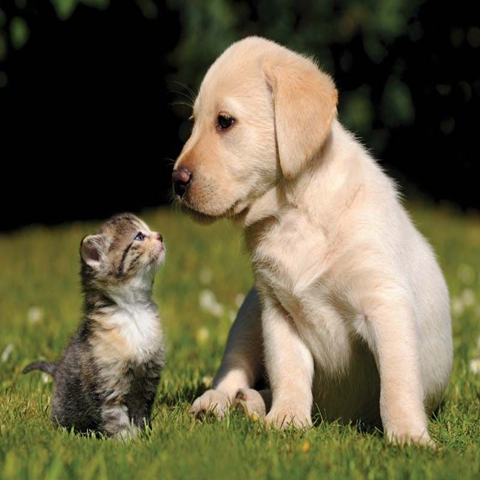

In [51]:
x = Image.open(loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')).resize((480,480))
x.show()

In [41]:
import numpy as np

In [42]:
embedsim = np.array(loaded_json['embedsim'])

In [43]:
embedsim.shape

(1, 900, 900)

In [ ]:
import matplotlib.pyplot as plt

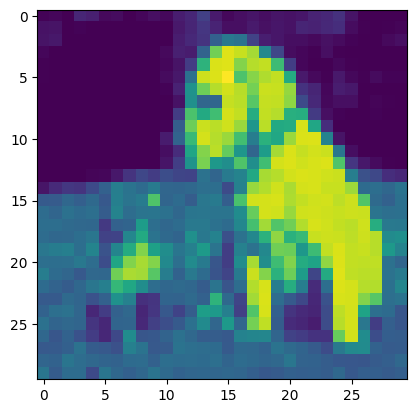

In [45]:
plt.imshow(embedsim[0,30*5+15].reshape((30,30)))

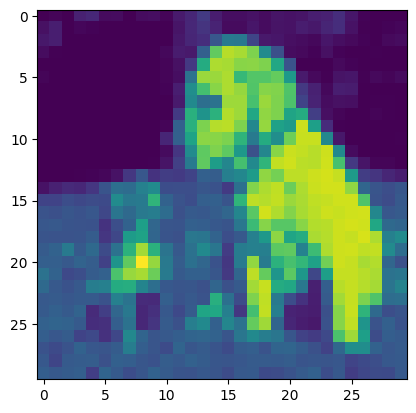

In [46]:
plt.imshow(embedsim[0,30*20+8].reshape((30,30)))

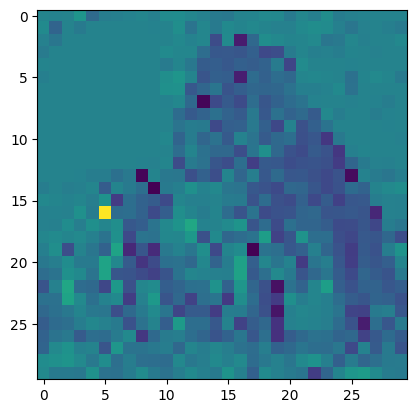

In [47]:
plt.imshow(embedsim[0,30*16+5].reshape((30,30)))

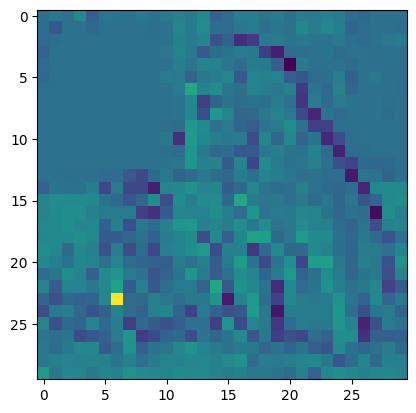

In [48]:
plt.imshow(embedsim[0,:,30*23+6].reshape((30,30)))

In [25]:

from timm.models.vision_transformer import _cfg, PatchEmbed

In [50]:
patch_embed = PatchEmbed(
            img_size=480, patch_size=16, in_chans=3, embed_dim=768)

In [62]:
np.expand_dims(np.asarray(x),0).shape

(1, 480, 480, 3)

In [63]:
patch_embed(np.expand_dims(np.asarray(x),0))

AssertionError: Input image width (3) doesn't match model (480).

In [11]:

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

In [12]:
def load_demo_image(image_size,device,img_url):
    if 'http' in img_url:
        img = Image.open(requests.get(img_url, stream=True).raw)
    else:
        img = Image.open(img_url)
    raw_image = img.convert('RGB')

    w,h = raw_image.size

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

In [71]:
img_embed = patch_embed(load_demo_image(480,'cpu',loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')))

In [72]:
img_embed.shape

torch.Size([1, 900, 768])

In [ ]:

        # a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
        # a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
        # b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
        # sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))

In [79]:
import torch

In [119]:
img_embed.shape

torch.Size([1, 900, 768])

In [123]:
img_embed[0].norm(dim=1)[:, None].shape

torch.Size([900, 1])

In [129]:
a_n = img_embed[0].norm(dim=1)[:, None] #a.norm(dim=1)[:, None]
a_norm = img_embed[0] / torch.max(a_n) #, eps * torch.ones_like(a_n))
sim_mt = torch.mm(a_norm, a_norm.T).detach().numpy()

In [125]:
sim_mt.shape

torch.Size([900, 900])

In [81]:
torch.mm(img_embed[0],img_embed[0].transpose(0, 1))

tensor([[684.1731, 667.6631, 697.7782,  ..., 160.2858, 180.5213, 165.5812],
        [667.6631, 660.6252, 685.3339,  ..., 158.5717, 178.9615, 163.8458],
        [697.7782, 685.3339, 715.0615,  ..., 162.7423, 184.7227, 168.7631],
        ...,
        [160.2858, 158.5717, 162.7423,  ...,  69.0248,  68.9300,  68.0838],
        [180.5213, 178.9615, 184.7227,  ...,  68.9300,  73.4976,  68.7914],
        [165.5812, 163.8458, 168.7631,  ...,  68.0838,  68.7914,  71.9028]],
       grad_fn=<MmBackward0>)

In [85]:
result = (img_embed[0]@img_embed[0].T).detach().numpy()

In [86]:
result.shape

(900, 900)

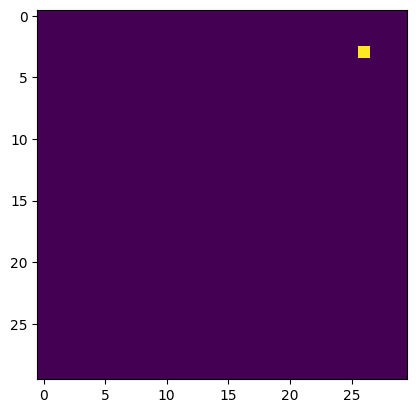

In [126]:
plt.imshow((sim_mt[:,30*0+20] == max(sim_mt[:,30*0+20])).reshape(30,30))

In [128]:
sim_mt.shape

torch.Size([900, 900])

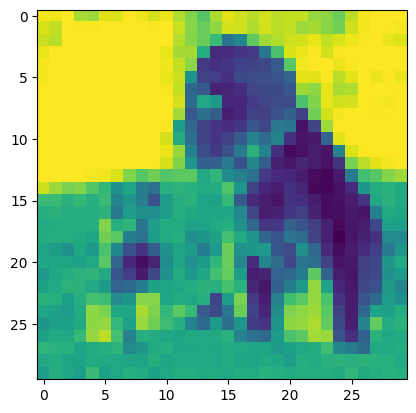

In [140]:
plt.imshow(sim_mt[:,30*5+25].reshape((30,30)))

In [141]:
import torch

In [144]:
model = torch.load('model_base_vqa_capfilt_large.pth')

In [146]:
model['model'].keys()

odict_keys(['visual_encoder.cls_token', 'visual_encoder.pos_embed', 'visual_encoder.patch_embed.proj.weight', 'visual_encoder.patch_embed.proj.bias', 'visual_encoder.blocks.0.norm1.weight', 'visual_encoder.blocks.0.norm1.bias', 'visual_encoder.blocks.0.attn.qkv.weight', 'visual_encoder.blocks.0.attn.qkv.bias', 'visual_encoder.blocks.0.attn.proj.weight', 'visual_encoder.blocks.0.attn.proj.bias', 'visual_encoder.blocks.0.norm2.weight', 'visual_encoder.blocks.0.norm2.bias', 'visual_encoder.blocks.0.mlp.fc1.weight', 'visual_encoder.blocks.0.mlp.fc1.bias', 'visual_encoder.blocks.0.mlp.fc2.weight', 'visual_encoder.blocks.0.mlp.fc2.bias', 'visual_encoder.blocks.1.norm1.weight', 'visual_encoder.blocks.1.norm1.bias', 'visual_encoder.blocks.1.attn.qkv.weight', 'visual_encoder.blocks.1.attn.qkv.bias', 'visual_encoder.blocks.1.attn.proj.weight', 'visual_encoder.blocks.1.attn.proj.bias', 'visual_encoder.blocks.1.norm2.weight', 'visual_encoder.blocks.1.norm2.bias', 'visual_encoder.blocks.1.mlp.fc1.w

In [1]:
from models.blip_vqa import blip_vqa
image_size = 480

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
#model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_vqa.pth'

model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')

/home/bjoern_deiseroth/miniconda3/envs/git/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERTY CONFIG BertConfig {
  "add_cross_attention": true,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "encoder_width": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30524
}

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


In [15]:
import torch

In [13]:
img_embed = model.visual_encoder.patch_embed(load_demo_image(480,'cpu',loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')))

In [31]:
a_n = img_embed[0].norm(dim=1)[:, None] #a.norm(dim=1)[:, None]
a_norm = img_embed[0] / torch.max(a_n) #, eps * torch.ones_like(a_n))
sim_mt = torch.mm(a_norm, a_norm.T).detach().numpy()

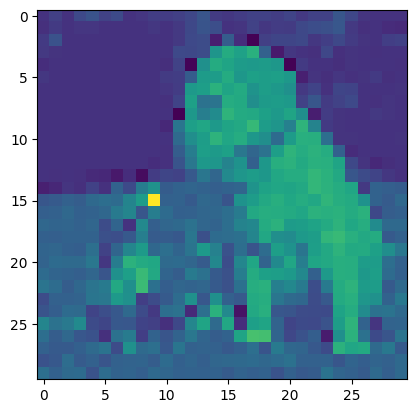

In [23]:
plt.imshow(sim_mt[:,30*15+9].reshape((30,30)))

In [48]:
patch_embed2 = PatchEmbed(
            img_size=480, patch_size=16, in_chans=3, embed_dim=5)

In [49]:
img_embed2 = patch_embed2(load_demo_image(480,'cpu',loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')))

In [50]:
a_n = img_embed2[0].norm(dim=1)[:, None] #a.norm(dim=1)[:, None]
a_norm = img_embed2[0] / torch.max(a_n) #, eps * torch.ones_like(a_n))
sim_mt2 = torch.mm(a_norm, a_norm.T).detach().numpy()

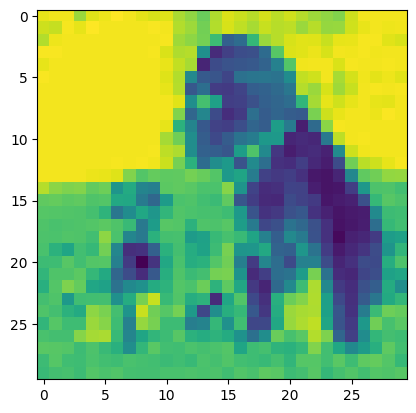

In [53]:
plt.imshow(sim_mt2[:,30*17+10].reshape((30,30)))

In [54]:
model.visual_encoder.patch_embed

PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)

In [ ]:

clip.load(ViT-B/16, device='cpu', jit=False)

In [57]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image

#Load CLIP model
model = SentenceTransformer('clip-ViT-B-16')

#Encode an image:
img_emb_clip = model.encode(Image.open(loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')))


In [59]:
img_emb_clip.shape

(512,)

In [1]:

import clip

In [2]:

encoder = clip.load('RN50x16')[0].visual

In [9]:
encoder.enc

AttributeError: 'ModifiedResNet' object has no attribute 'enc'

In [7]:
img_emb_clip = encoder(Image.open(loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')))


AttributeError: type

In [1]:
from magma import Magma
from magma.image_input import ImageInput

model = Magma.from_checkpoint(
    config_path = "configs/MAGMA_v1.yml",
    checkpoint_path = "./mp_rank_00_model_states.pt",
    device = 'cuda:0'
)

/home/bjoern_deiseroth/miniconda3/envs/magma_/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


checkpoint: ./mp_rank_00_model_states.pt does not exist, downloading model


Downloading...
From: https://bit.ly/aleph-alpha-magma-download
To: /nfs/scratch_2/bjoern/atman_other_model/others/BLIP/mp_rank_00_model_states.pt
100%|██████████| 13.0G/13.0G [08:46<00:00, 24.7MB/s] 


Loading GPTJ language model...
loading magma checkpoint from: ./mp_rank_00_model_states.pt
magma successfully loaded


In [11]:
embeddings = model.preprocess_inputs([ImageInput(loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')) ])

In [15]:
import torch

In [19]:
a_n = embeddings[0].norm(dim=1)[:, None] #a.norm(dim=1)[:, None]
a_norm = embeddings[0] / torch.max(a_n) #, eps * torch.ones_like(a_n))
a_norm = a_norm.to('cuda:0')
sim_mt = torch.mm(a_norm, a_norm.T).detach().cpu().numpy()

In [21]:
sim_mt.shape

(144, 144)

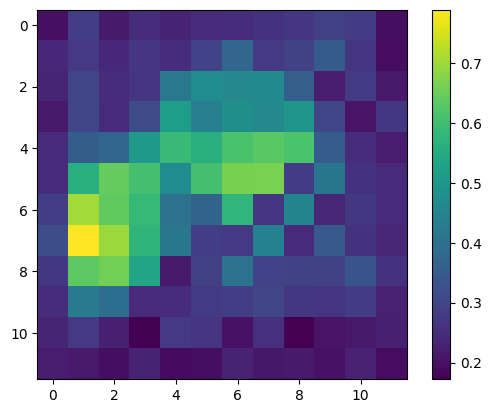

In [37]:
plt.imshow(sim_mt[:,7*12+1].reshape((12,12)))
plt.colorbar()

In [39]:
import cv2

In [42]:
from skimage.transform import resize


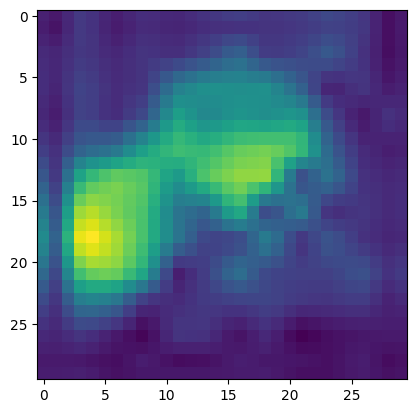

In [45]:
plt.imshow(resize(sim_mt[:,7*12+1].reshape((12,12)), (30, 30)))

In [40]:
cv2.resize(sim_mt[:,7*12+1].reshape((12,12)), dsize=(30, 30), interpolation=cv2.INTER_CUBIC)


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


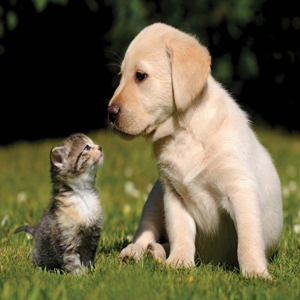

In [33]:
Image.open(loaded_json['img'].replace('/root/bjoern/atman_other_model','/nfs/scratch_2/bjoern/atman_other_model')).resize((300,300))

In [3]:
import pickle

In [4]:
from matplotlib import pyplot as plt

In [5]:
with open('test_folder/cat-and-dog.jpg_similarity.pickle', 'rb') as f:
    x = pickle.load(f)

In [7]:
x[0].shape

(30, 30)

/tmp/ipykernel_161222/3730035056.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


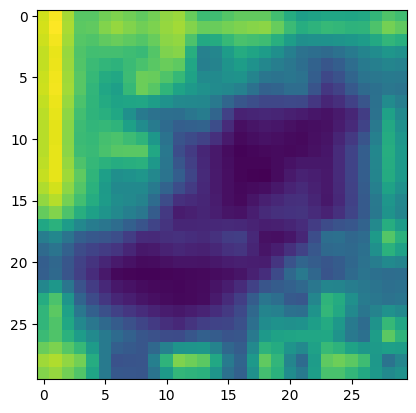

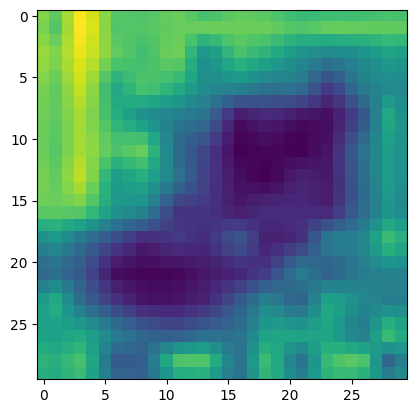

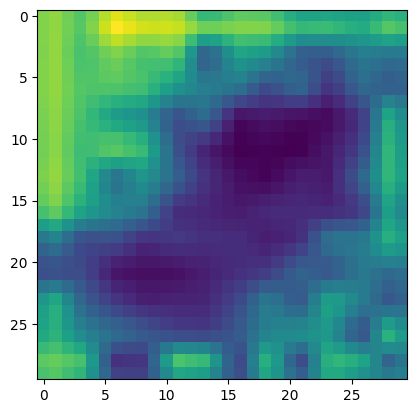

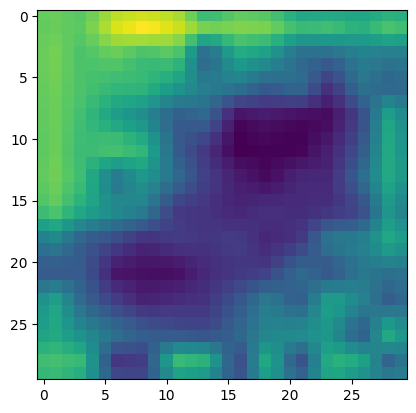

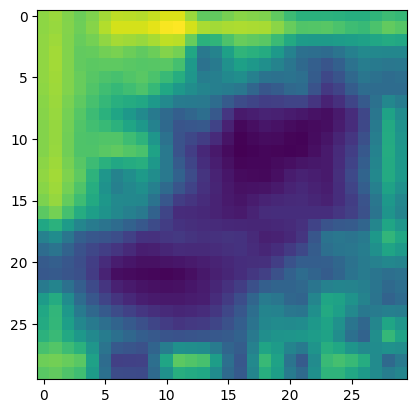

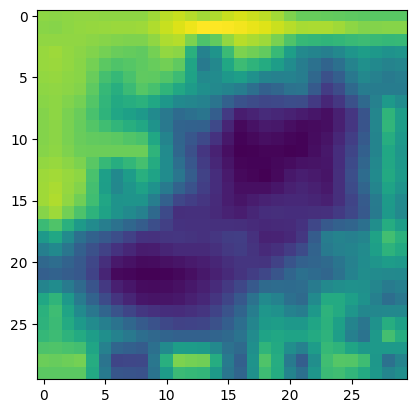

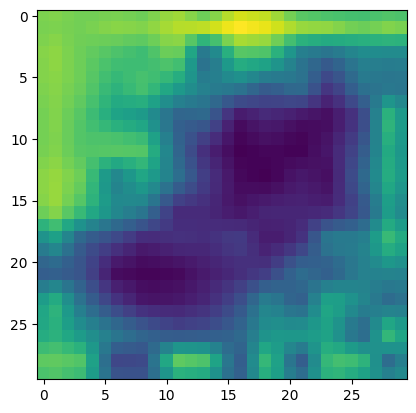

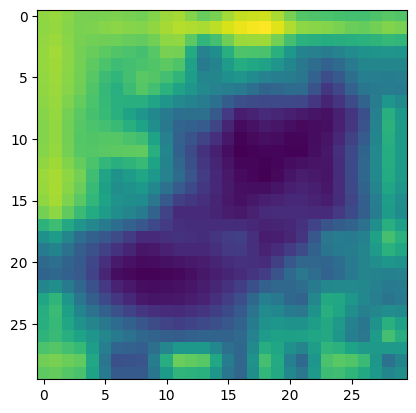

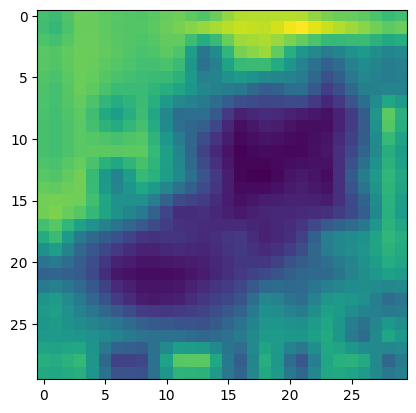

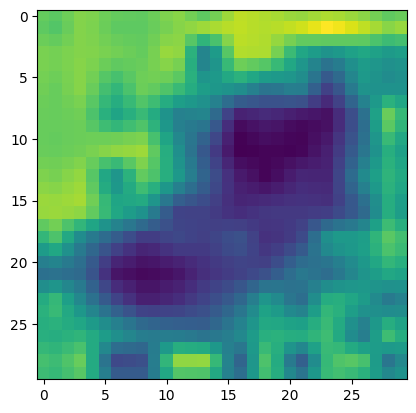

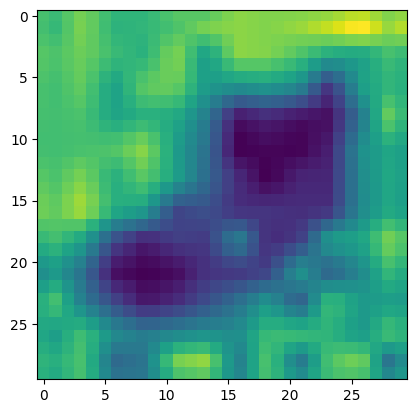

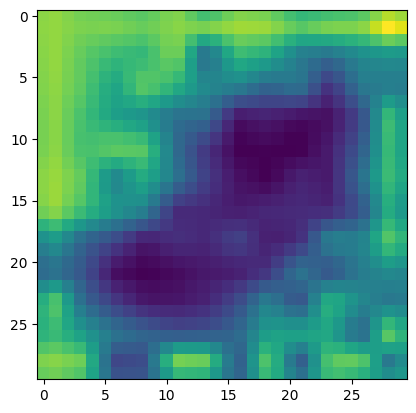

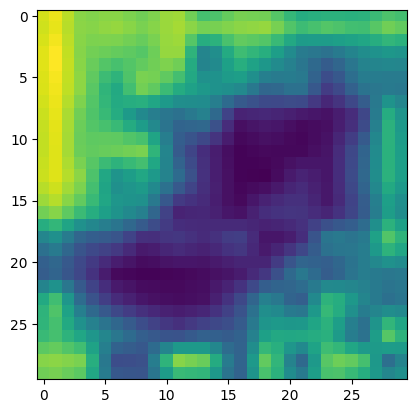

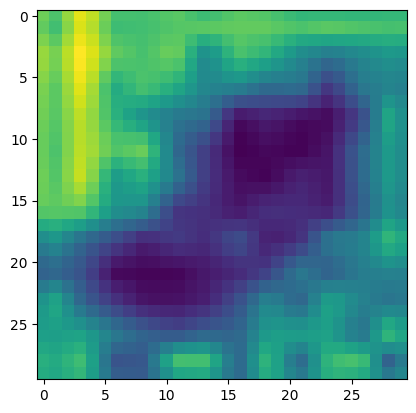

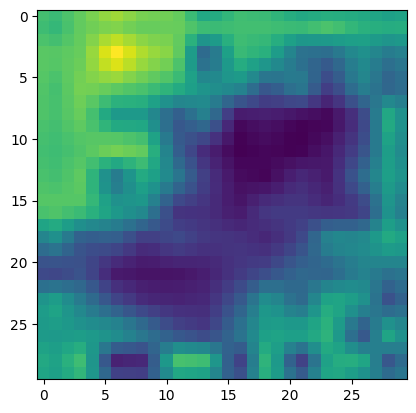

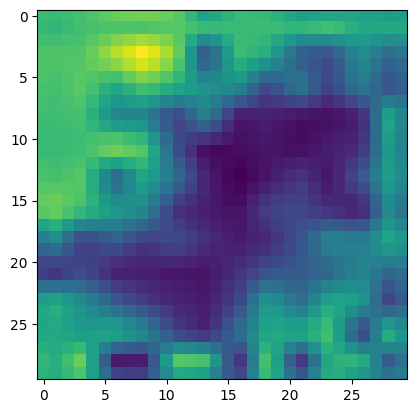

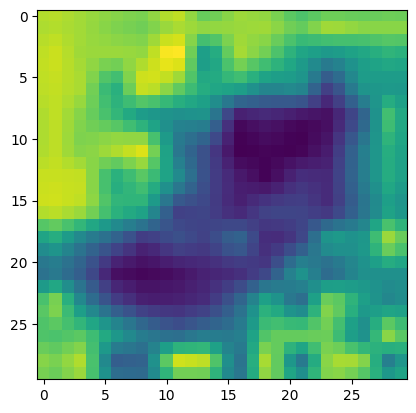

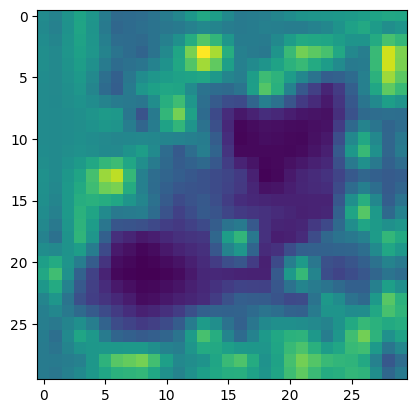

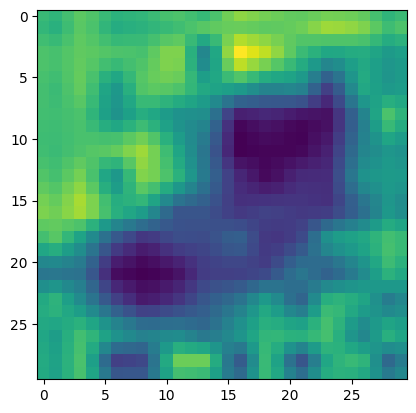

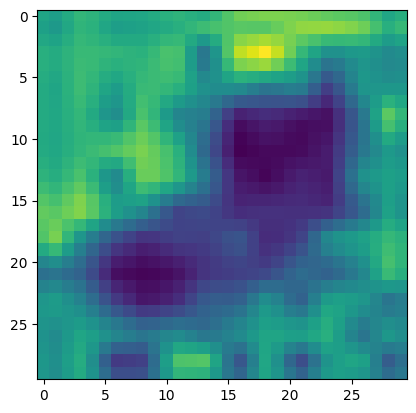

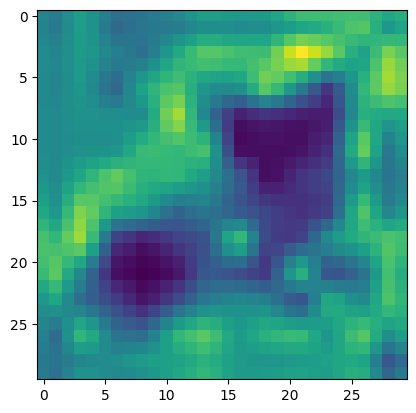

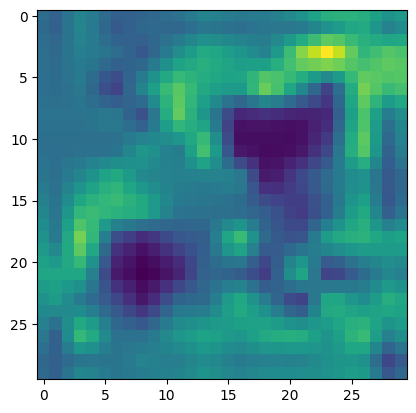

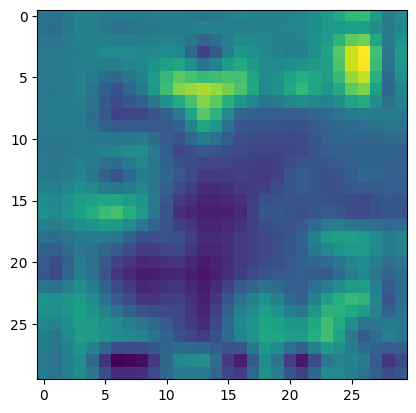

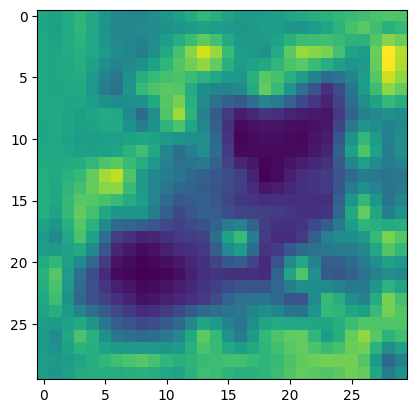

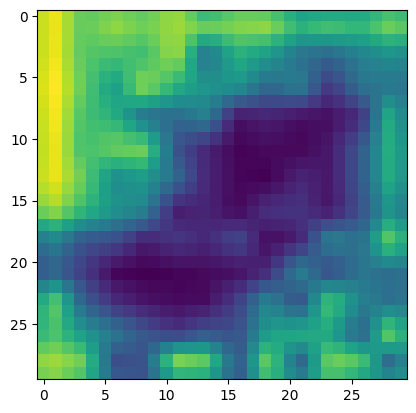

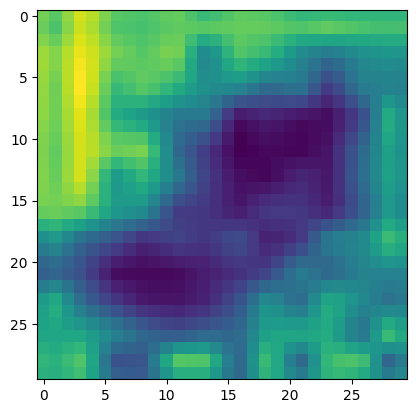

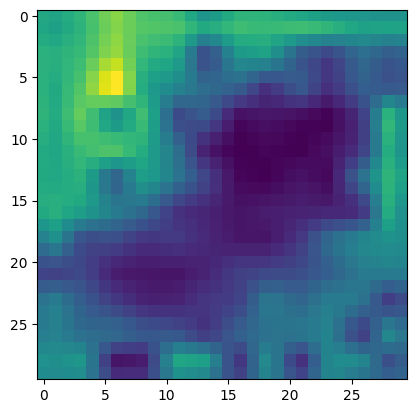

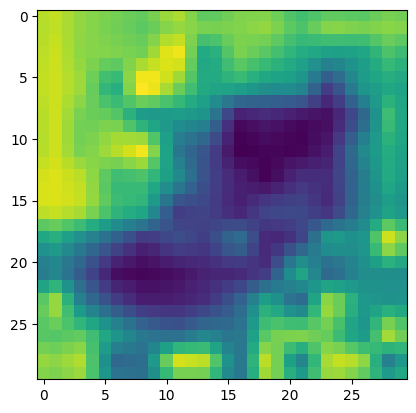

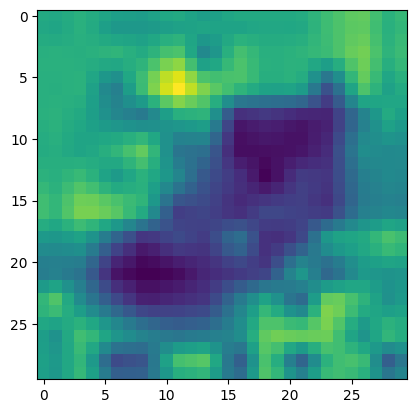

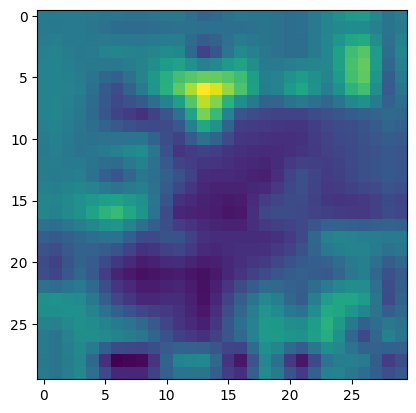

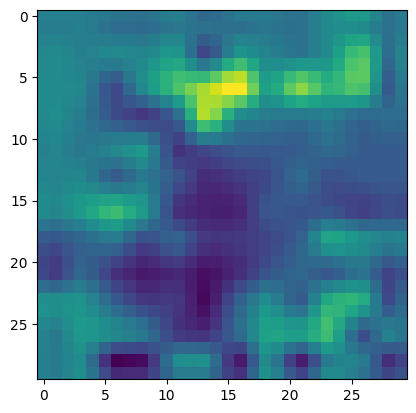

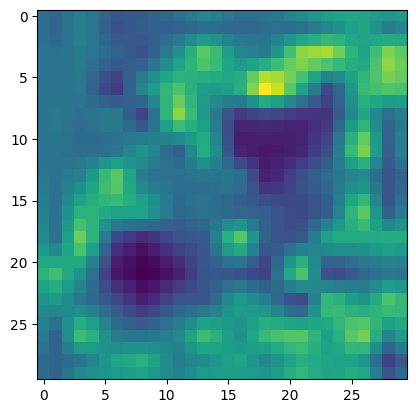

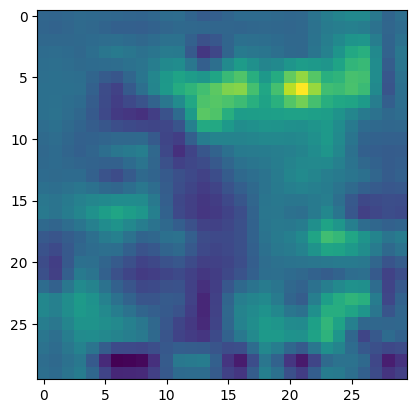

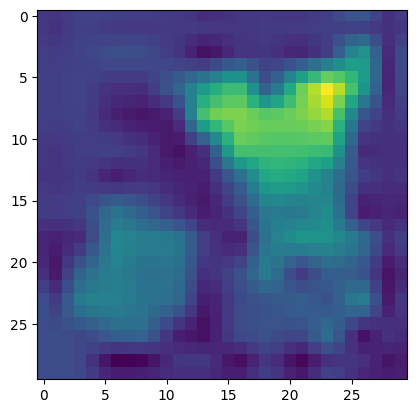

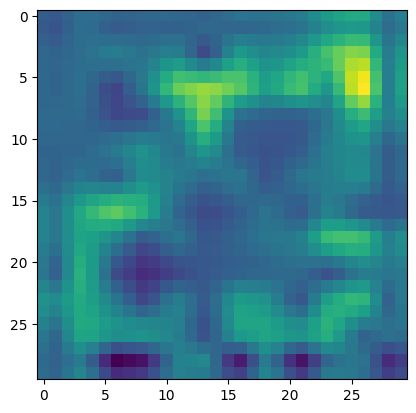

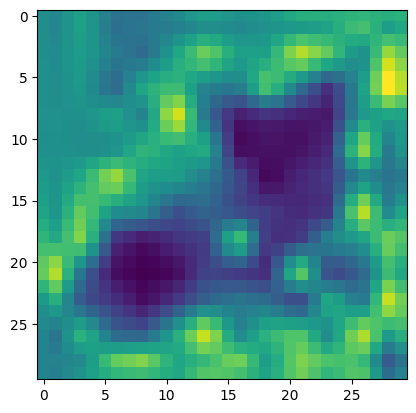

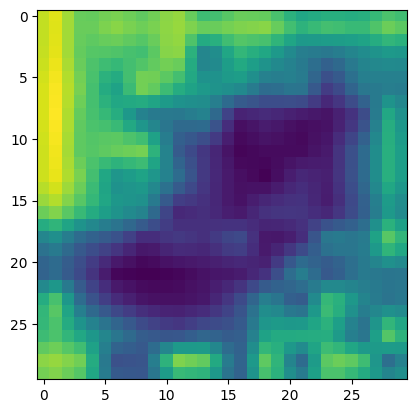

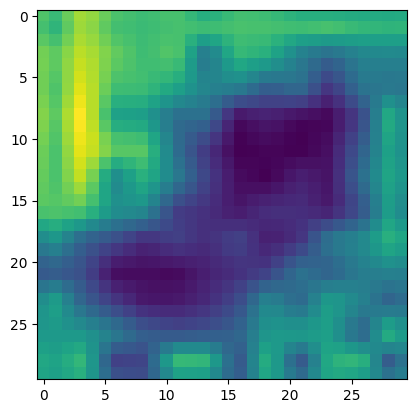

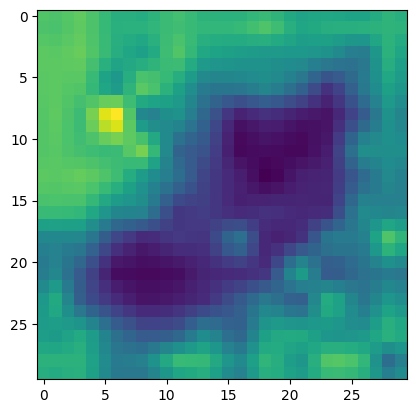

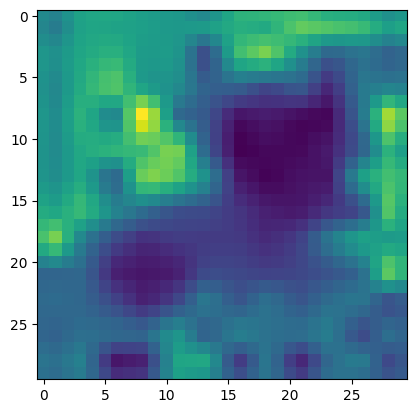

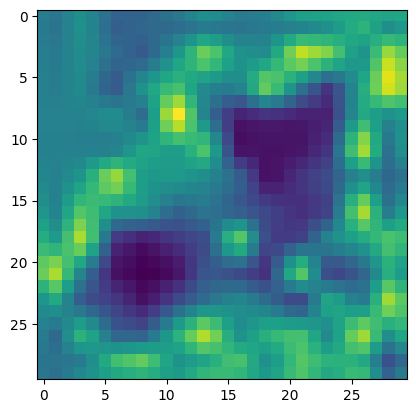

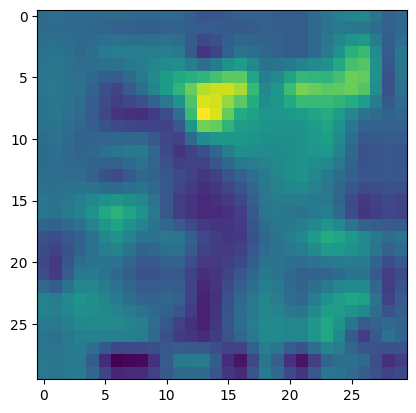

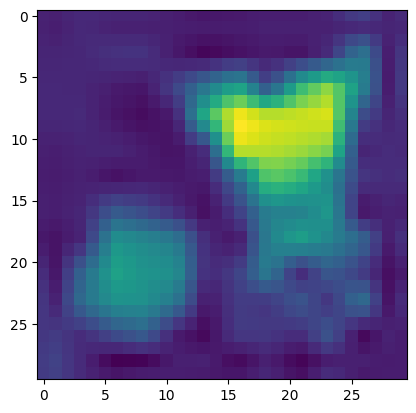

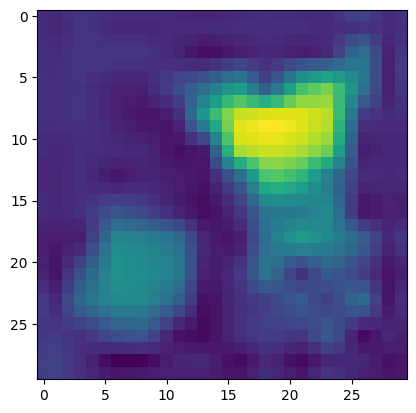

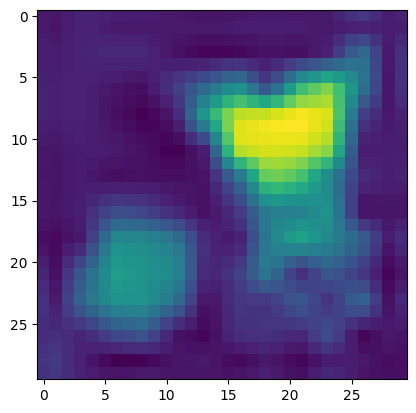

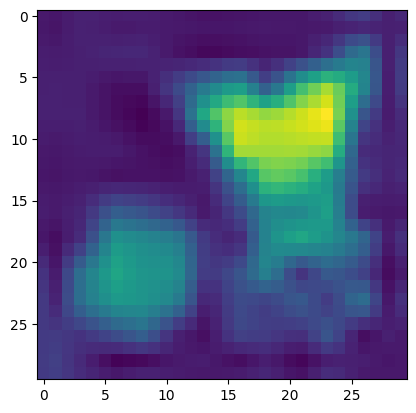

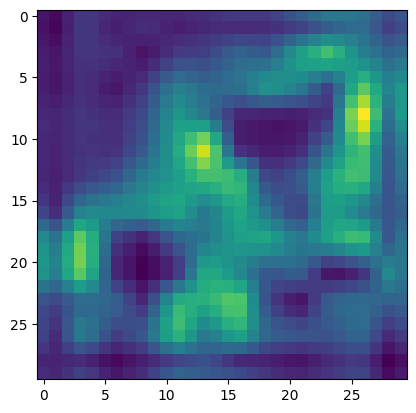

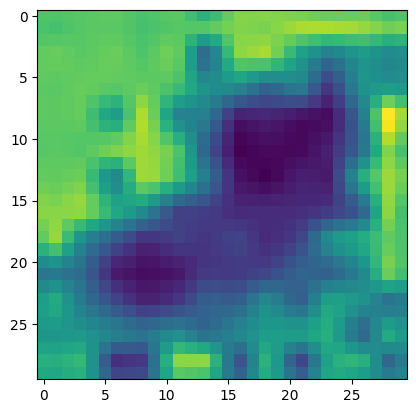

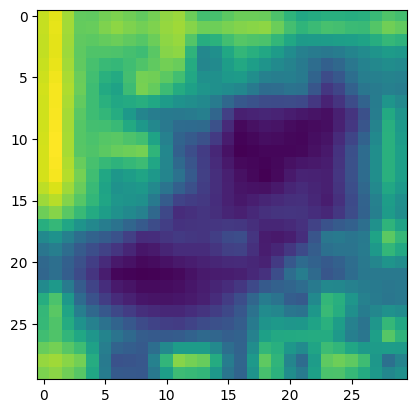

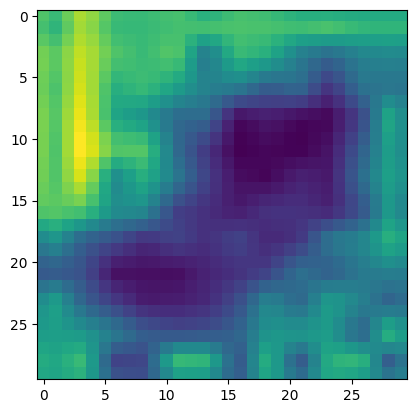

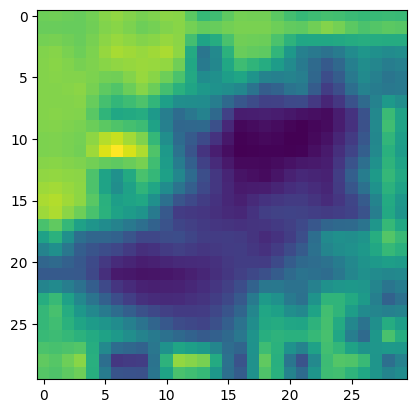

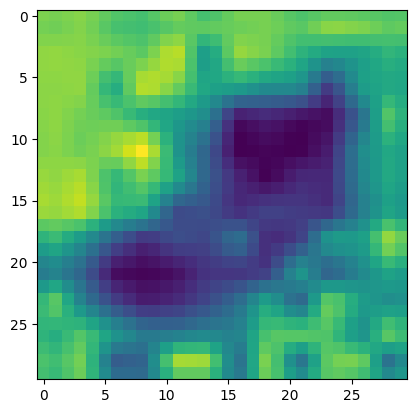

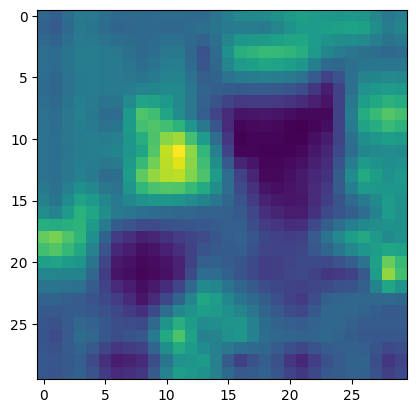

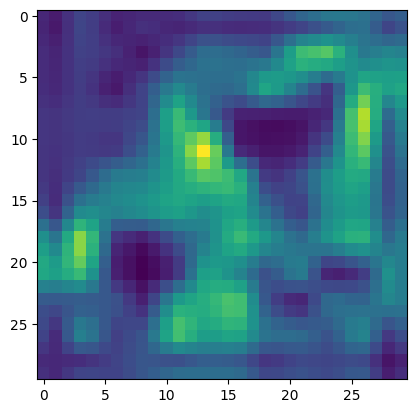

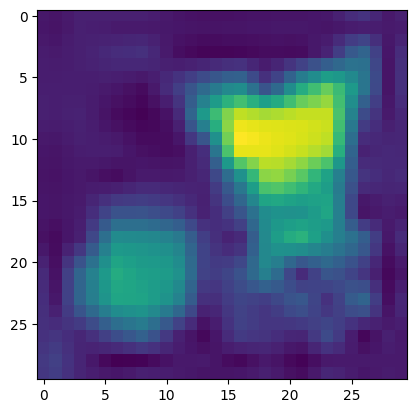

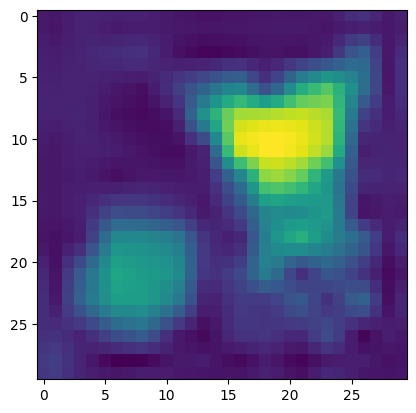

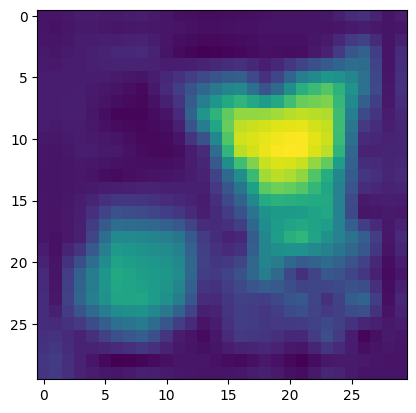

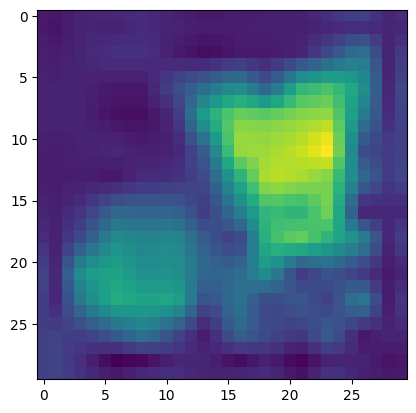

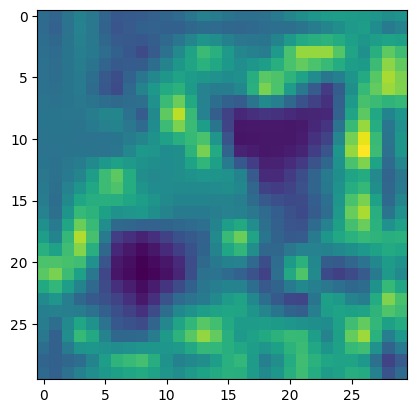

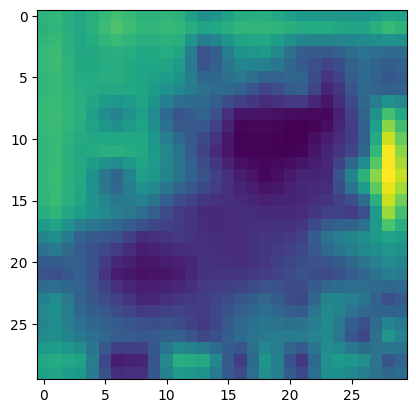

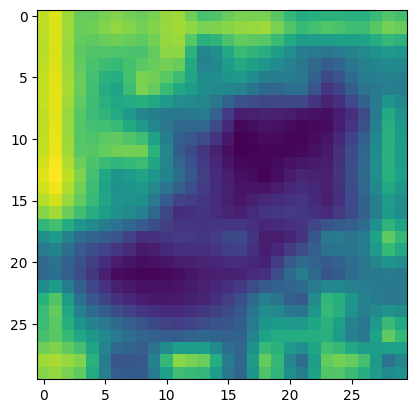

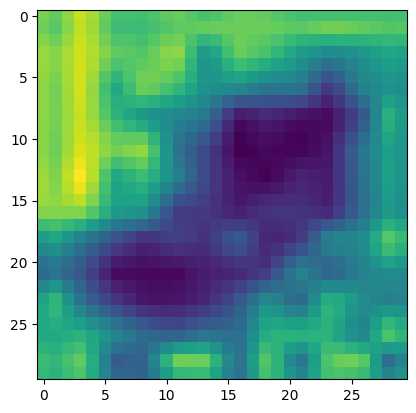

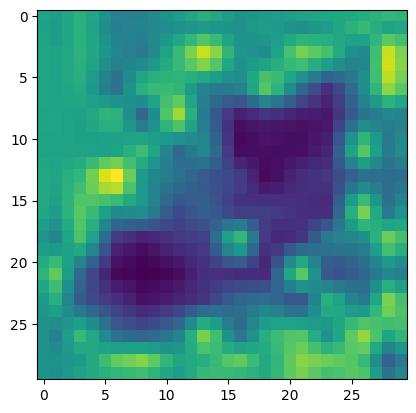

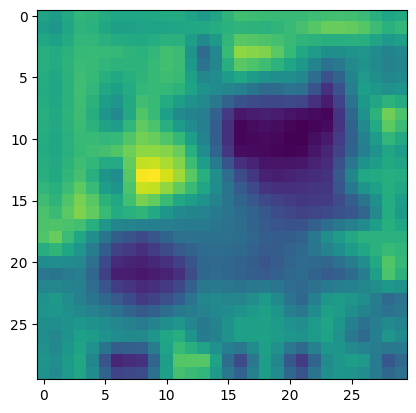

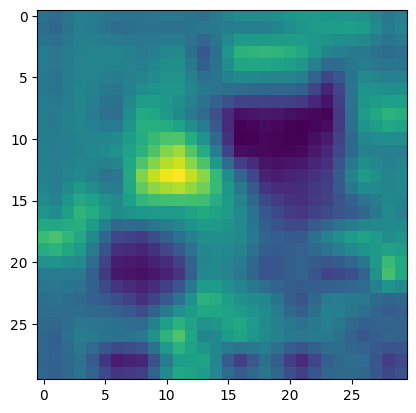

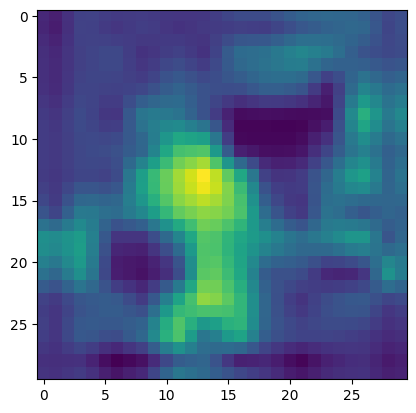

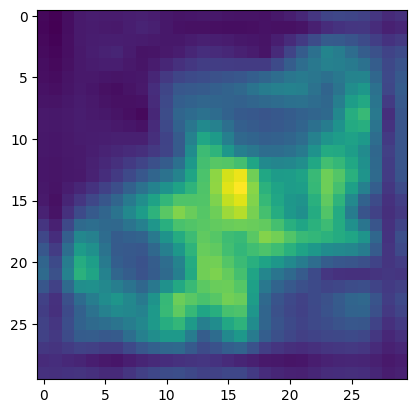

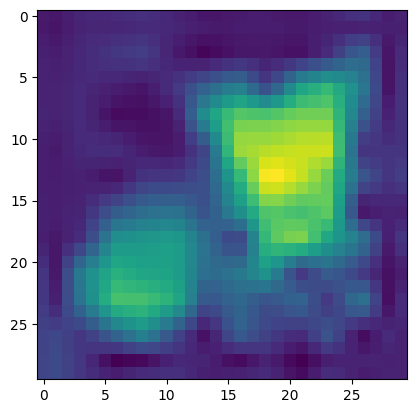

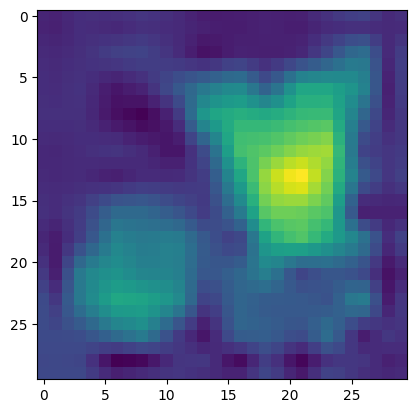

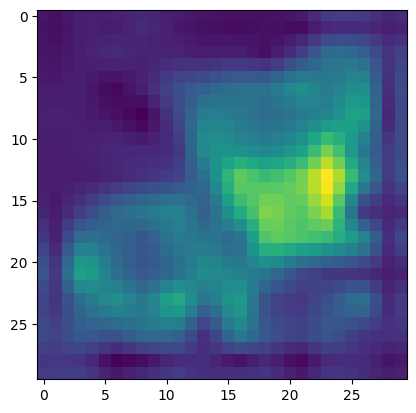

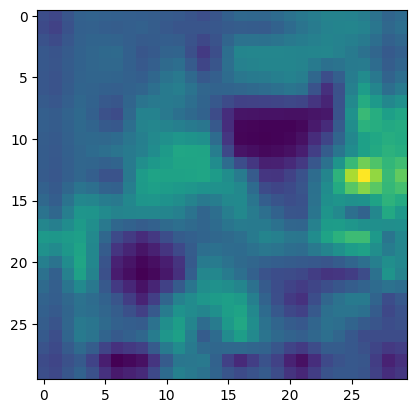

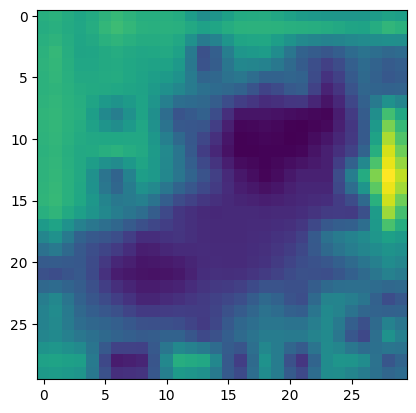

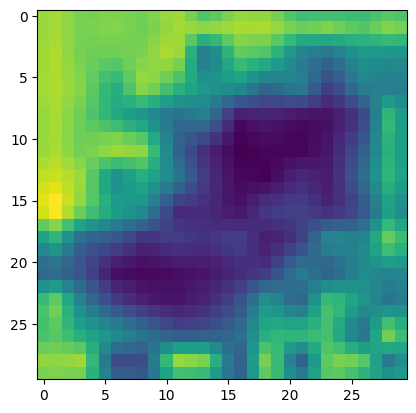

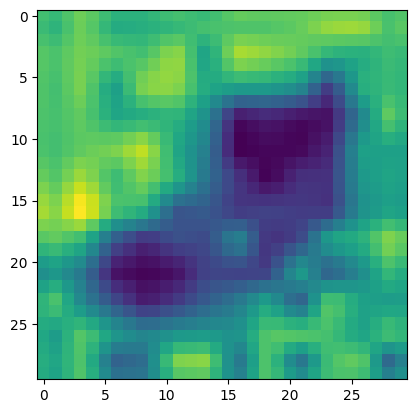

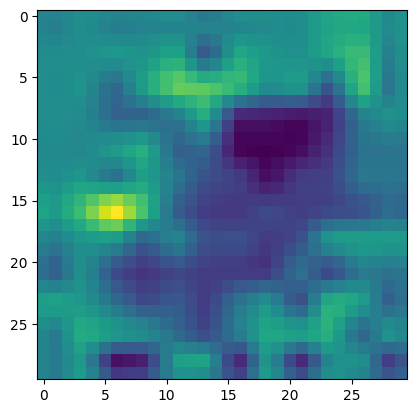

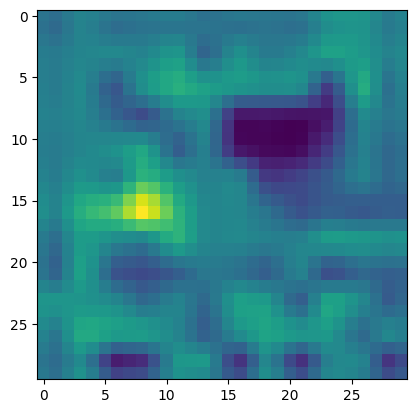

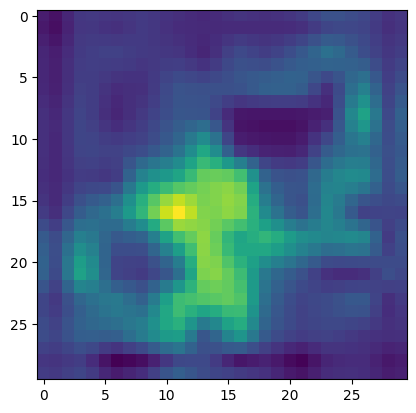

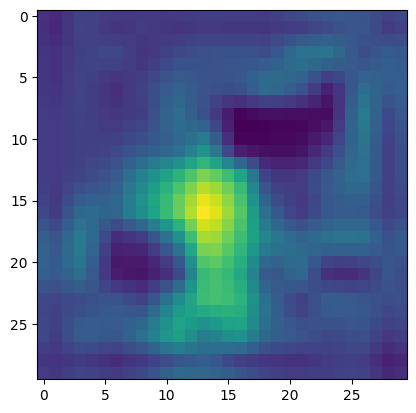

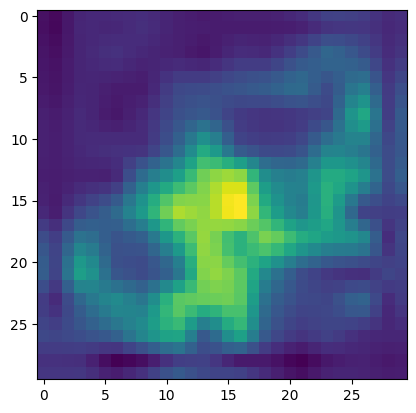

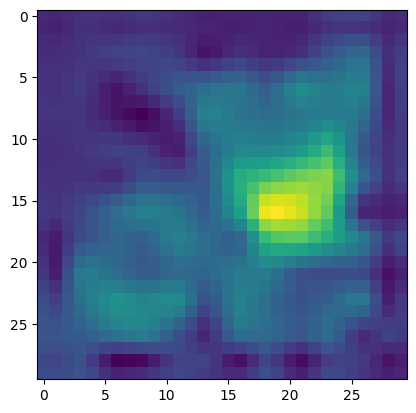

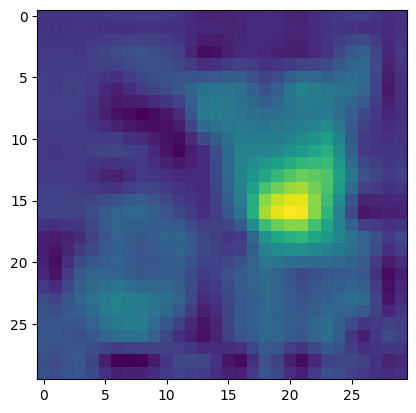

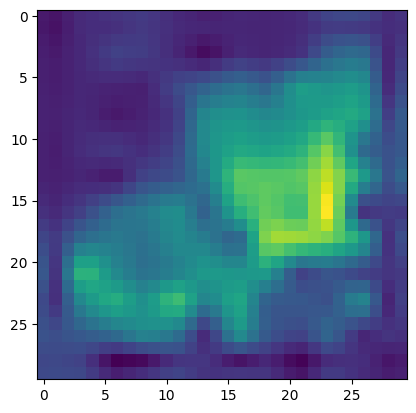

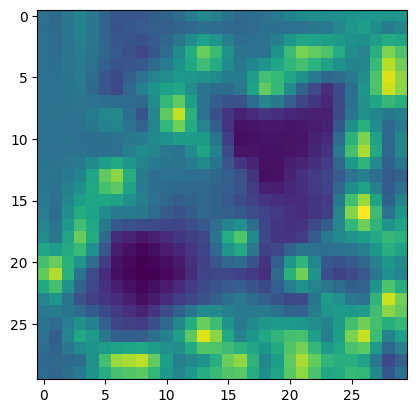

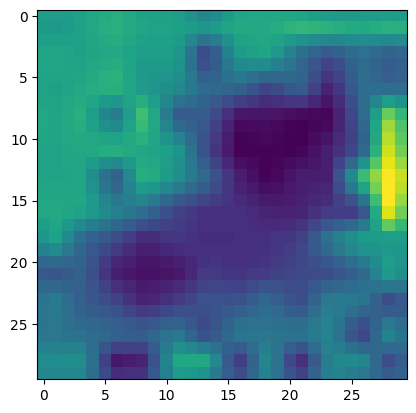

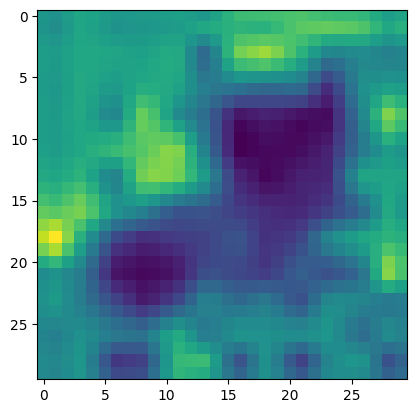

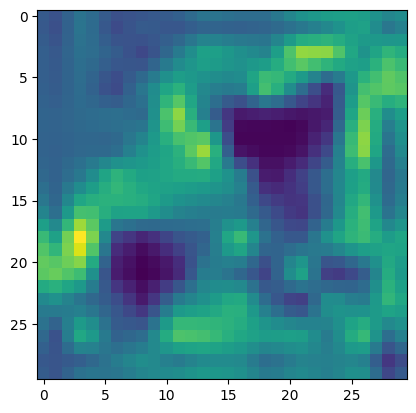

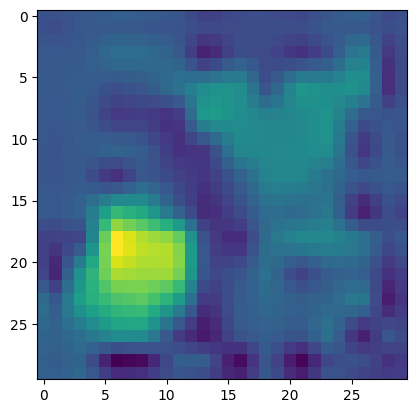

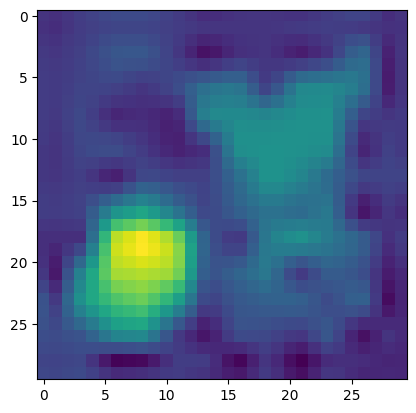

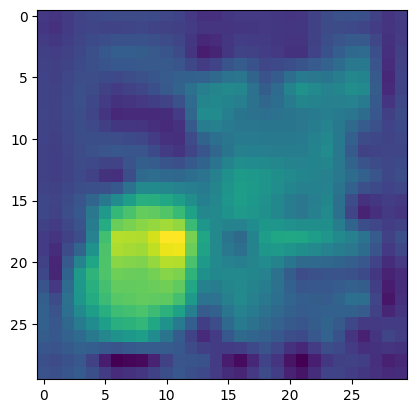

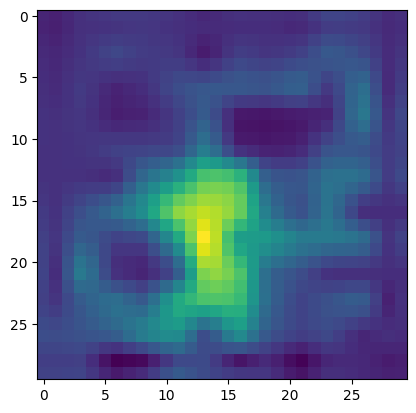

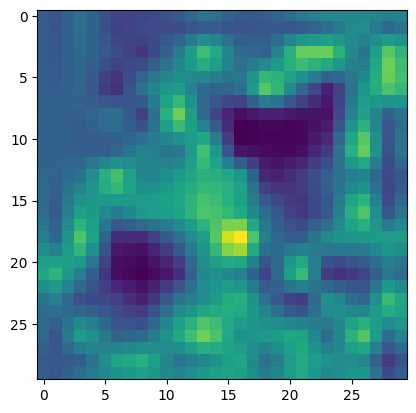

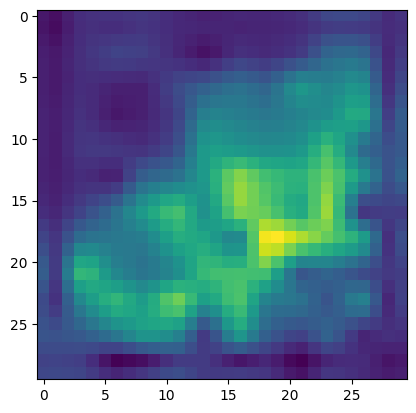

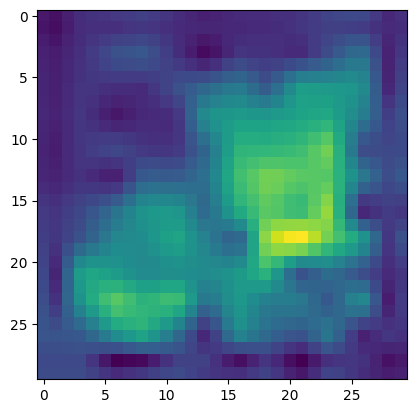

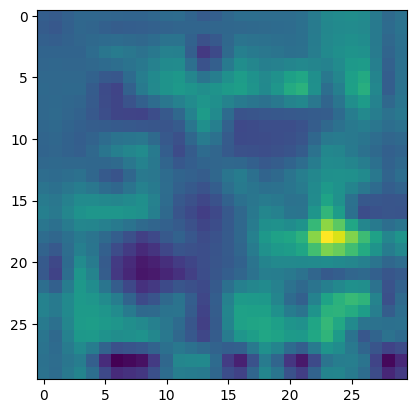

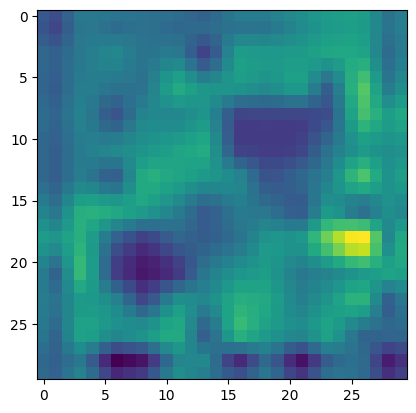

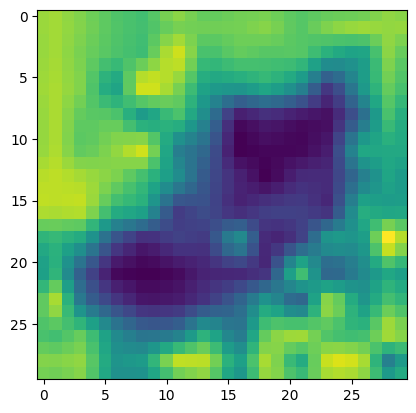

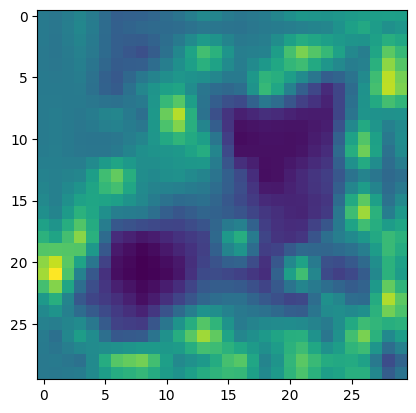

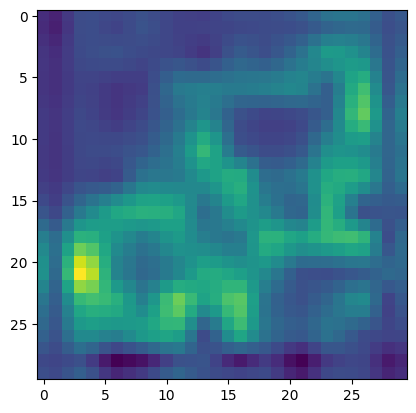

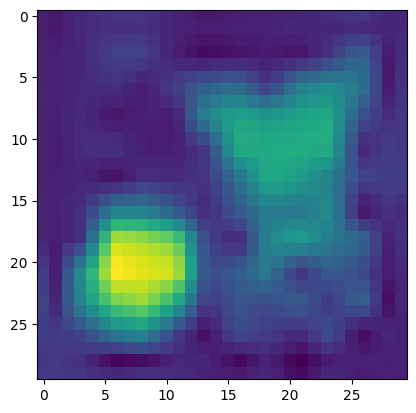

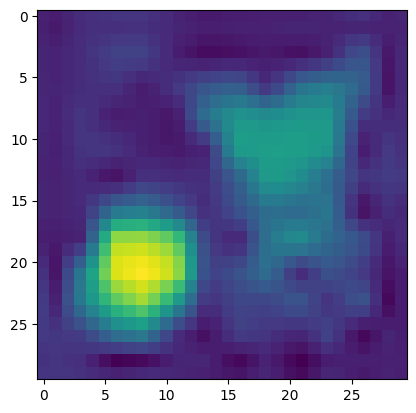

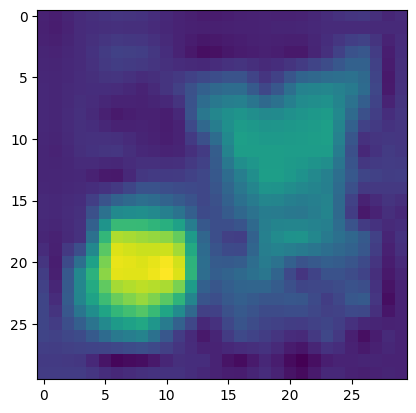

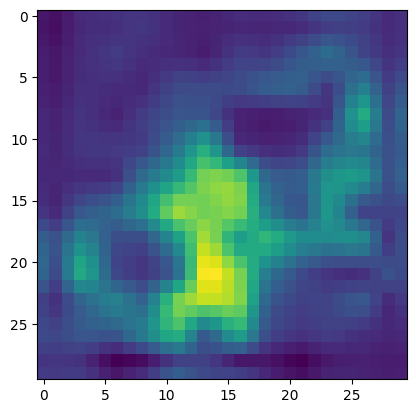

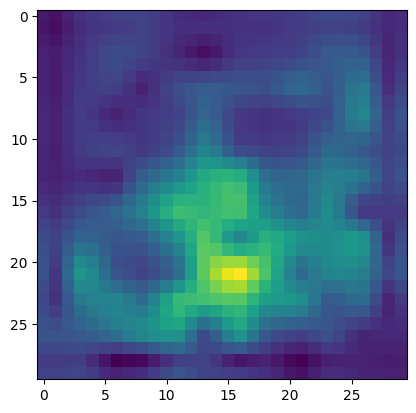

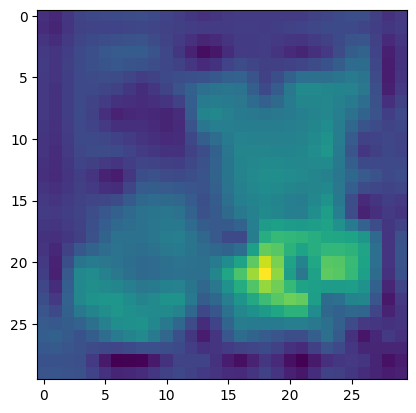

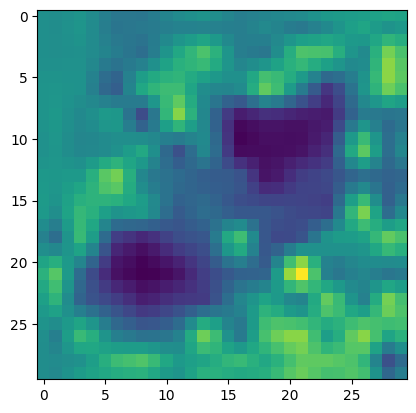

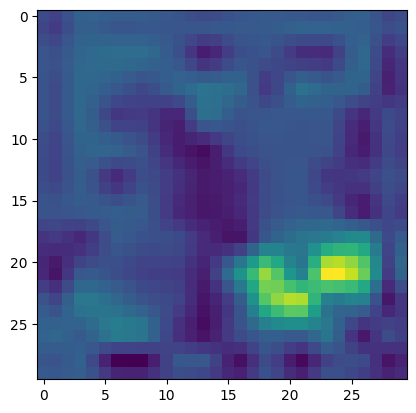

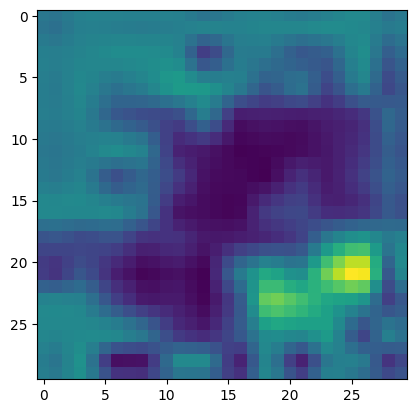

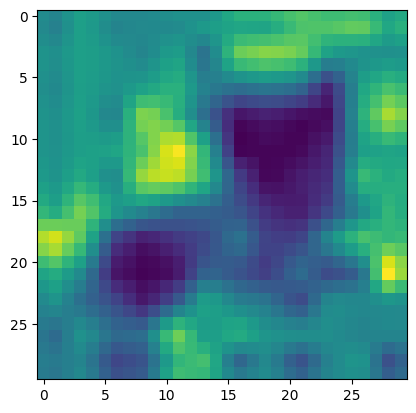

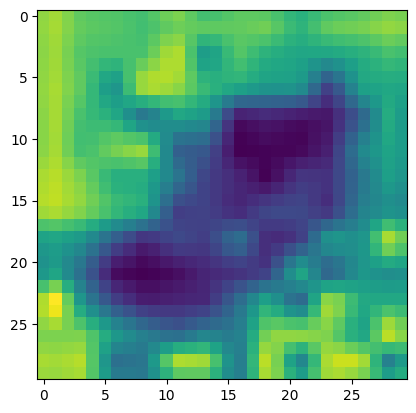

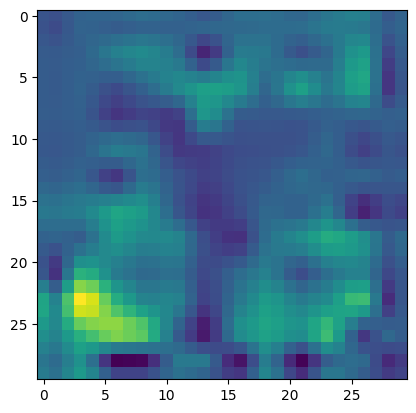

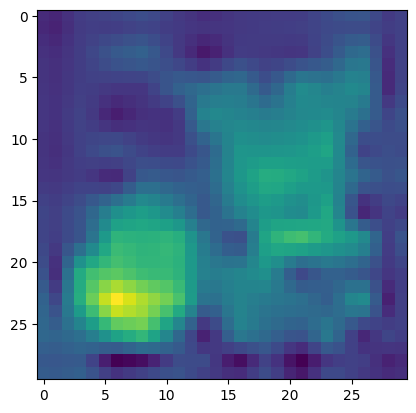

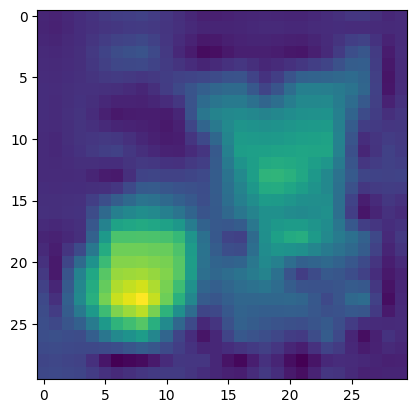

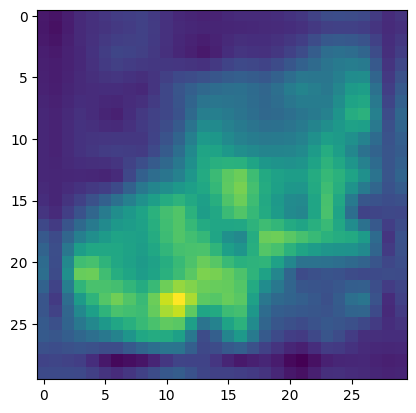

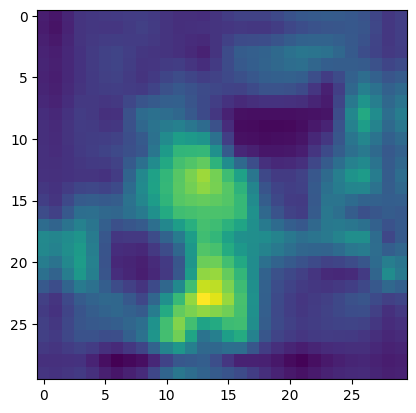

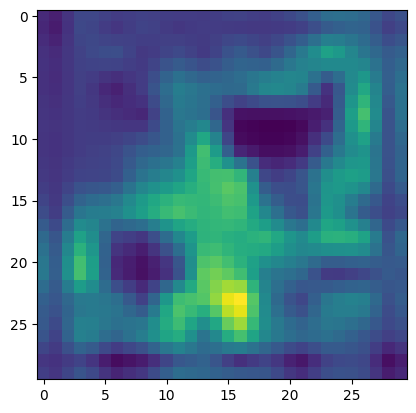

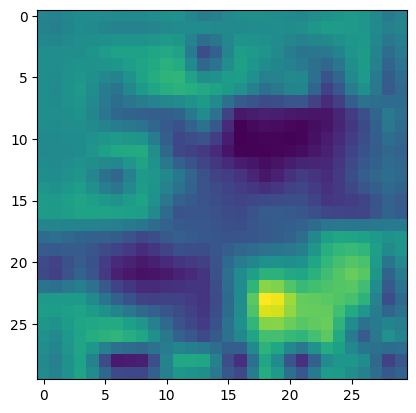

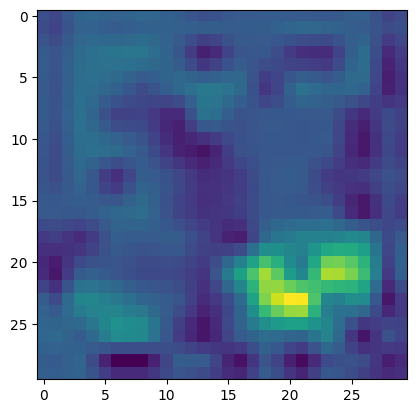

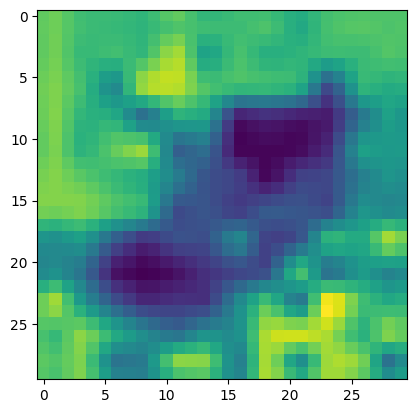

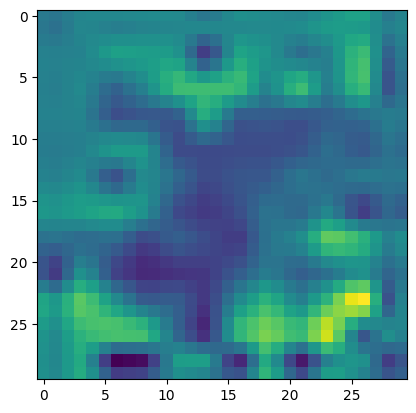

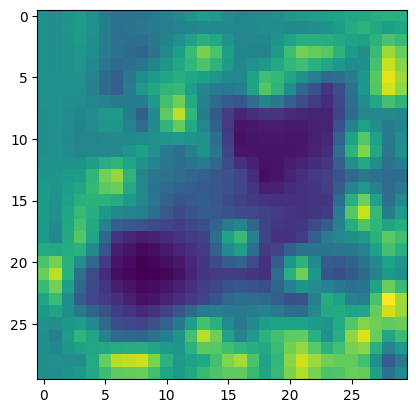

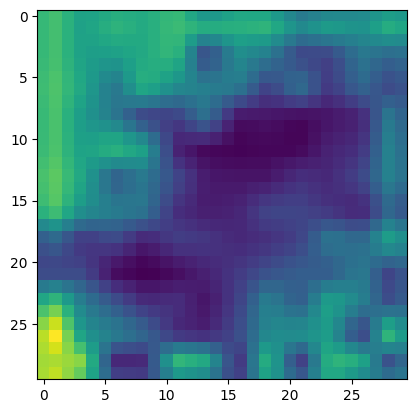

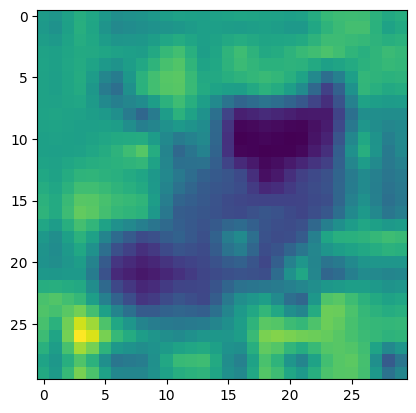

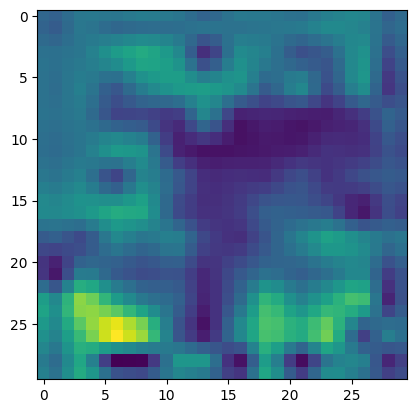

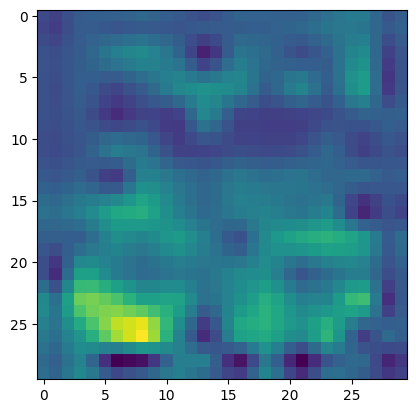

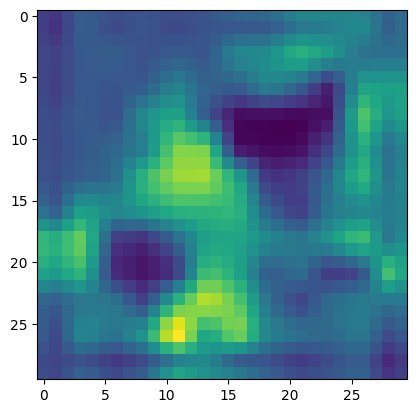

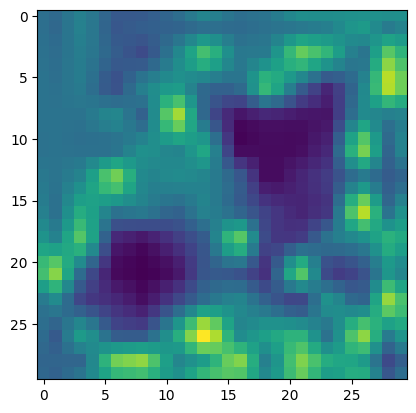

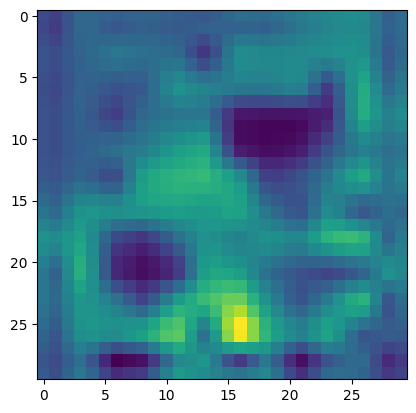

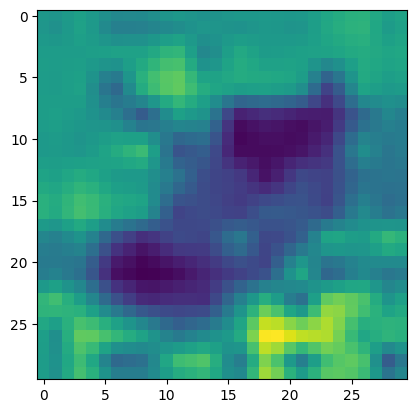

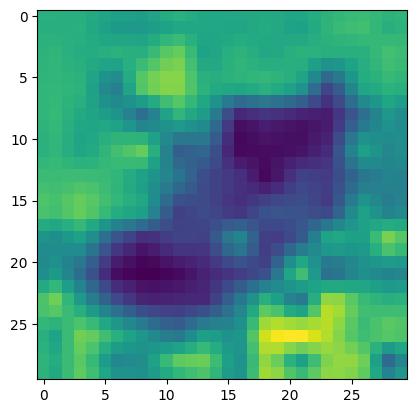

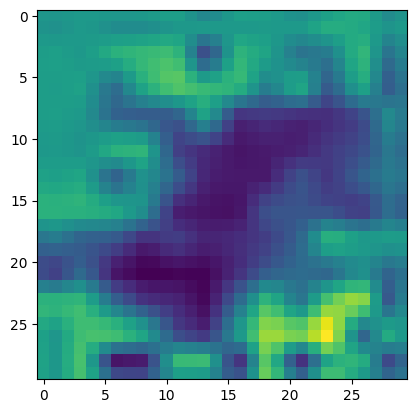

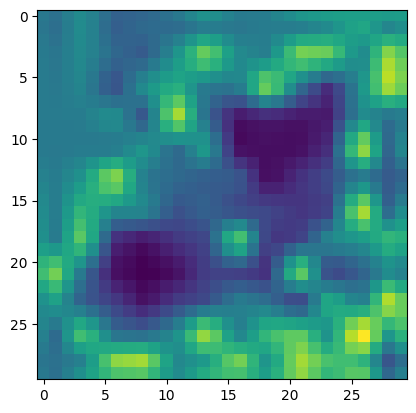

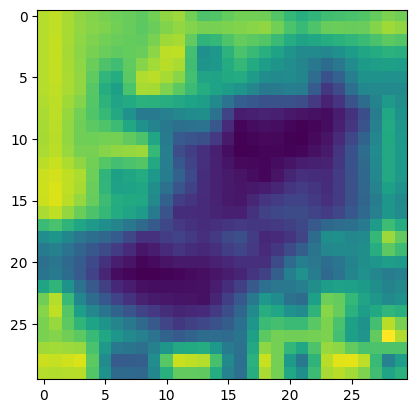

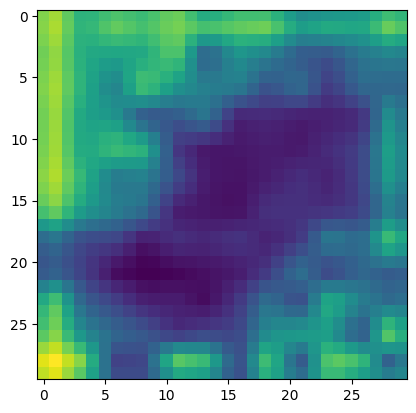

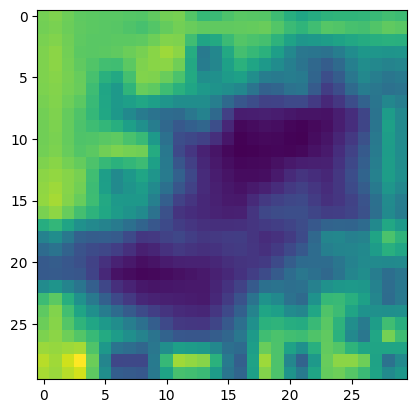

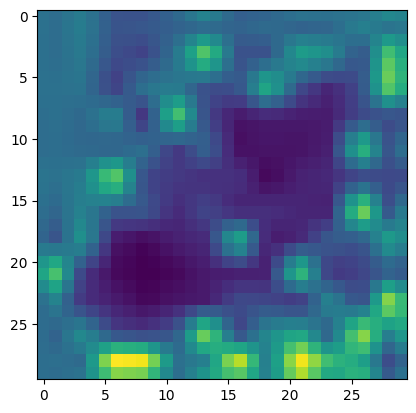

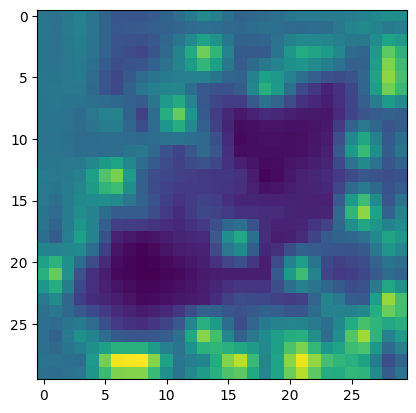

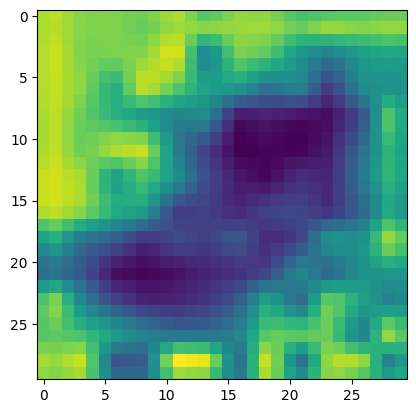

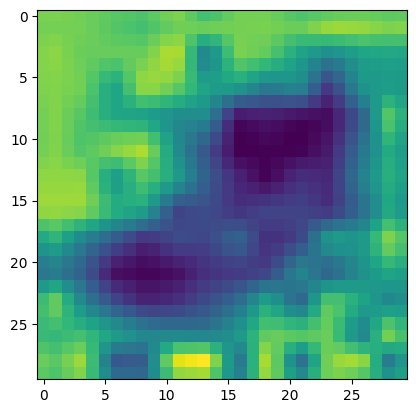

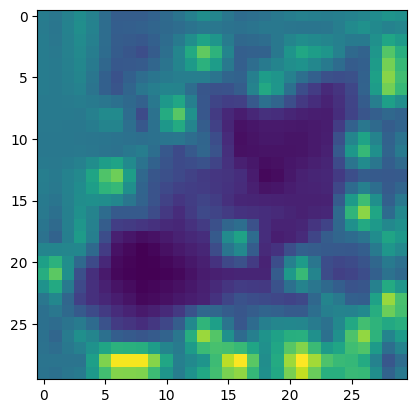

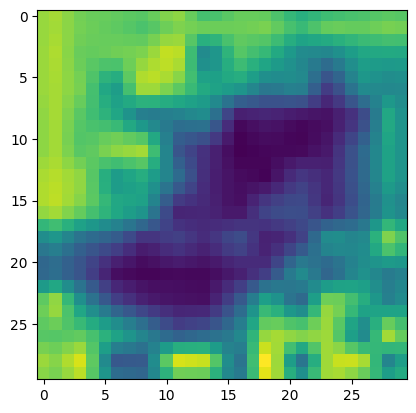

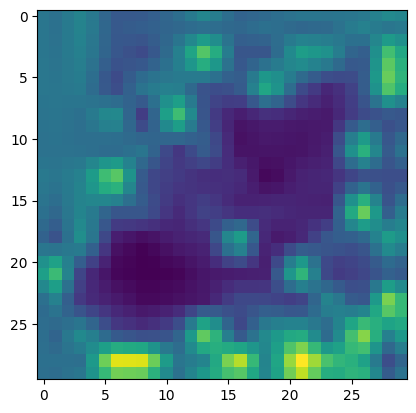

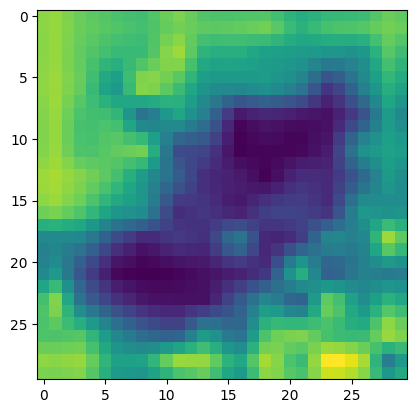

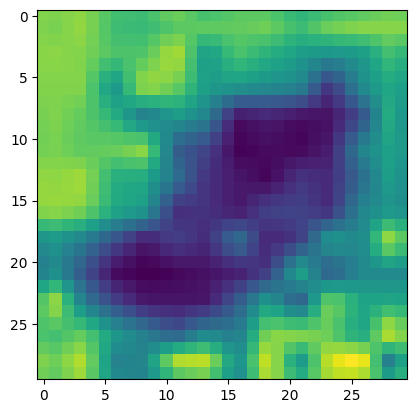

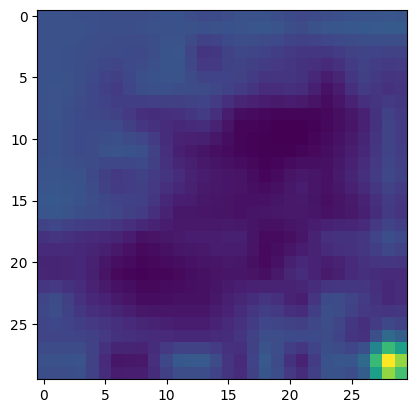

In [7]:
for i in x:
    plt.figure()
    plt.imshow(i)